In [3]:
import numpy as np
import pandas as pd
import torch
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Batch
from torch_geometric.transforms import LocalDegreeProfile
import torch.nn.functional as F
from torch_geometric.datasets import GemsecDeezer
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, average_precision_score
import pathlib
import utils
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# finding the current path
base_dir = pathlib.Path().resolve()

# GNN class definement

In [6]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hid_channels, out_channels):
        super(GNN, self).__init__()
        torch.manual_seed(0)
        self.conv1 = GCNConv(in_channels=in_channels, out_channels=hid_channels)
        self.conv2 = GCNConv(in_channels=hid_channels, out_channels=hid_channels)
        self.conv3 = GCNConv(in_channels=hid_channels, out_channels=out_channels)
        # self.lin1 = torch.nn.Linear(in_features=hid_channels, out_features=out_channels)

    def forward(self, x, edge_index, index=0):
        # print(x)
        x = self.conv1(x, edge_index)
        # print(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        # x = self.lin1(x)
        # x = x.sigmoid()
        return x

# Loading datasets

In [7]:
# loading the finger similarity into dataframe
df = pd.read_csv(f'{base_dir}/datasets/fingerSimilarity.csv')
# loading drug side effects file
se_df = pd.read_csv(f'{base_dir}/datasets/sideEffectsfillterd.csv')
drug_dccs = list(se_df['DCC_ID'].to_numpy())

higher than 0.80 similarity : 109, 708
higher than 0.50 similarity : 296, 1085

# Creating a graph of input drugs

In [13]:
def create_graph_of_input_drugs(df, se_df, least_score=0.85, consider_edge_attrs=True):
    # change least_score for changing minimum similarity score
    table = utils.get_top_cells(df, least_score=least_score)
    # loading all edges and scores
    all_edges = []
    all_edges_scores = []
    nodes_list = list()
    nodes_dict = dict()
    reverse_node_data_dict = dict()
    count = 0
    # assigning numbers to nodes and their features
    for row in table:
        score = row[2]
        d1 = row[0]
        d2 = row[1]
        edge = [row[0], row[1]]
        reverse_edge = [row[1], row[0]]
        if edge not in all_edges and reverse_edge not in all_edges:
            # adding edges with DCC code
            all_edges.append(edge)
            all_edges.append(reverse_edge)
            # adding edges scores
            all_edges_scores.append(float(score))
            all_edges_scores.append(float(score))
        if d1 not in nodes_list:
            nodes_list.append(d1)
            nodes_dict[d1] = count
            reverse_node_data_dict[count] = d1
            count += 1
        if d2 not in nodes_list:
            nodes_list.append(d2)
            nodes_dict[d2] = count
            reverse_node_data_dict[count] = d2
            count += 1

    all_edges_coded = []
    for row in table:
        d1 = nodes_dict[row[0]]
        d2 = nodes_dict[row[1]]
        edge = [d1, d2]
        reverse_edge = [d2, d1]
        if edge not in all_edges_coded and reverse_edge not in all_edges_coded:
            all_edges_coded.append(edge)
            all_edges_coded.append(reverse_edge)

    nodes_data = []

    for row in se_df.iloc[:, :se_df.shape[1]].values:
        drug = np.squeeze(row[se_df.shape[1]-1:])
        if drug in list(nodes_dict.keys()):
            nodes_data.append(list(row[1:se_df.shape[1]-1]))
    nodes_data = np.array(nodes_data)
    print(nodes_data.shape)
    # Selecting only the features (columns) that both 1 and 0 exists
    cols = []
    for i in range(nodes_data.shape[1]):
        col = nodes_data[:, i]
        if 1 in col:
            cols.append(col)
    cols = np.array(cols)
    nodes_data = cols.T
    # converting numpy arrays to tensors to feed GNN
    nodes_data = torch.from_numpy(np.array(nodes_data))
    edges_data = torch.from_numpy(np.array(all_edges_coded))
    edges_attr = torch.from_numpy(np.array(all_edges_scores))

    # data = Data(x=nodes_data, edge_index=edges_data.T, edge_attr=edges_attr)
    if consider_edge_attrs == True:
        data = Data(y=nodes_data, edge_index=edges_data.T, edge_attr=edges_attr)
    else:
        data = Data(y=nodes_data, edge_index=edges_data.T)
    # Automatically creating 5 node features
    ldp = LocalDegreeProfile()
    data = ldp(data)
    print(data)
    return data

# Training and testing the datasets

In [38]:
def train_and_test(data, GNN, epochs=101, with_auc=True, with_aupr=True, with_f1=False, plot_training=False, print_logs=True):
    # Hyper parameter selection
    in_channels = data.num_features
    hid_channels = 128
    out_channels = data.y.shape[1]
    # Model creation
    model = GNN(in_channels=in_channels, hid_channels=hid_channels, out_channels=out_channels)
    # Loss function
    criterion = torch.nn.BCEWithLogitsLoss()
    # Optimizer function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    # selecting CPU and GPU depending on the environment
    def device_finder():
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        return device
    # training the model
    losses = []
    auc_score_list = []
    f1score_list = []
    aupr_score_list = []
    f1 = 'N/A'
    aupr = 'N/A'
    auc_score = 'N/A'
    for epoch in range(epochs):
        output = model(data.x, data.edge_index)
        loss = criterion(output, data.y.float())
        loss = float("{:.3f}".format(loss.item()))
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        temp_outputs = output.clone().detach().numpy()
        temp_labels = np.array(data.y)
        try:
            # auc score calculation
            if with_auc == True:
                auc_score = roc_auc_score(temp_labels, temp_outputs, average='weighted')
                auc_score = float("{:.3f}".format(auc_score))
                auc_score_list.append(auc_score)
            # f1 score calculation
            if with_f1 == True:
                f1 = f1_score(temp_labels, temp_outputs, average='weighted')
                f1 = float("{:.3f}".format(f1))
                f1score_list.append(f1)
            # aupr score calculation
            if with_aupr == True:
                aupr = average_precision_score(temp_labels, temp_outputs, average='weighted')
                aupr = float("{:.3f}".format(aupr))
                aupr_score_list.append(aupr)
        except Exception as e:
            print(e)
        if epoch % 10 == 0 and print_logs == True:
            print(f'Epoch: {epoch}, Loss: {loss}, AUC Score: {auc_score}, F1 Score: {f1}, AUPR Score: {aupr}')
    # plotting results
    if plot_training == True:
        utils.train_result_plotting(losses, 'Loss')
        if with_auc == True:
            utils.train_result_plotting(auc_score_list, 'AUC scores')
        if with_aupr == True:
            utils.train_result_plotting(aupr_score_list, 'AUPR scores')
        if with_f1 == True:
            utils.train_result_plotting(f1score_list, 'F1 scores')

    return losses, auc_score_list, aupr_score_list

(78, 1090)
Data(edge_index=[2, 126], edge_attr=[126], y=[78, 601], x=[78, 5])
Epoch: 0, Loss: 0.699, AUC Score: 0.493, F1 Score: N/A, AUPR Score: 0.254
Epoch: 10, Loss: 0.232, AUC Score: 0.515, F1 Score: N/A, AUPR Score: 0.26
Epoch: 20, Loss: 0.194, AUC Score: 0.546, F1 Score: N/A, AUPR Score: 0.273
Epoch: 30, Loss: 0.192, AUC Score: 0.517, F1 Score: N/A, AUPR Score: 0.27
Epoch: 40, Loss: 0.18, AUC Score: 0.537, F1 Score: N/A, AUPR Score: 0.269
Epoch: 50, Loss: 0.179, AUC Score: 0.531, F1 Score: N/A, AUPR Score: 0.273
Epoch: 60, Loss: 0.18, AUC Score: 0.537, F1 Score: N/A, AUPR Score: 0.279
Epoch: 70, Loss: 0.175, AUC Score: 0.555, F1 Score: N/A, AUPR Score: 0.277
Epoch: 80, Loss: 0.172, AUC Score: 0.562, F1 Score: N/A, AUPR Score: 0.294
Epoch: 90, Loss: 0.171, AUC Score: 0.567, F1 Score: N/A, AUPR Score: 0.292
Epoch: 100, Loss: 0.175, AUC Score: 0.545, F1 Score: N/A, AUPR Score: 0.281


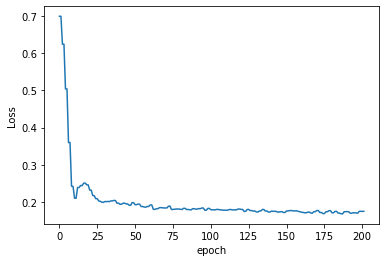

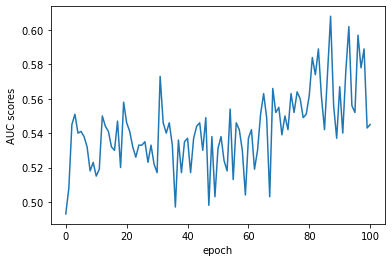

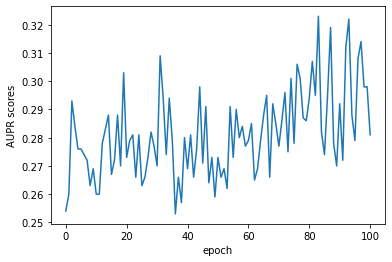

In [40]:
least_score = 0.85
data = create_graph_of_input_drugs(df, se_df, least_score=least_score, consider_edge_attrs=True)
loss_list, auc_list, aupr_list = train_and_test(data=data, GNN=GNN, epochs=101, with_auc=True, with_aupr=True, with_f1=False, plot_training=True)

In [64]:
# min_similarity_scores = [0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.5, 0.4, 0.3]
min_similarity_scores = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
epochs = 101
score_list = []

for min_score in min_similarity_scores:
    data = create_graph_of_input_drugs(df, se_df, least_score=min_score, consider_edge_attrs=True)
    loss_list, auc_list, aupr_list = train_and_test(data=data, GNN=GNN, epochs=epochs, with_auc=True, with_aupr=True, with_f1=False, plot_training=False)
    score_list.append([min_score, loss_list, auc_list, aupr_list])

(46, 1090)
Data(edge_index=[2, 56], edge_attr=[56], y=[46, 519], x=[46, 5])
Epoch: 0, Loss: 0.697, AUC Score: 0.504, F1 Score: N/A, AUPR Score: 0.28
Epoch: 10, Loss: 0.266, AUC Score: 0.521, F1 Score: N/A, AUPR Score: 0.285
Epoch: 20, Loss: 0.23, AUC Score: 0.513, F1 Score: N/A, AUPR Score: 0.275
Epoch: 30, Loss: 0.226, AUC Score: 0.53, F1 Score: N/A, AUPR Score: 0.286
Epoch: 40, Loss: 0.225, AUC Score: 0.512, F1 Score: N/A, AUPR Score: 0.273
Epoch: 50, Loss: 0.227, AUC Score: 0.503, F1 Score: N/A, AUPR Score: 0.268
Epoch: 60, Loss: 0.224, AUC Score: 0.522, F1 Score: N/A, AUPR Score: 0.303
Epoch: 70, Loss: 0.224, AUC Score: 0.533, F1 Score: N/A, AUPR Score: 0.286
Epoch: 80, Loss: 0.224, AUC Score: 0.504, F1 Score: N/A, AUPR Score: 0.263
Epoch: 90, Loss: 0.225, AUC Score: 0.48, F1 Score: N/A, AUPR Score: 0.258
Epoch: 100, Loss: 0.223, AUC Score: 0.511, F1 Score: N/A, AUPR Score: 0.267
(109, 1090)
Data(edge_index=[2, 212], edge_attr=[212], y=[109, 708], x=[109, 5])
Epoch: 0, Loss: 0.701,

In [62]:
def plot_different_results(loss_list, auc_list, aupr_list, min_score):
    plt.figure(figsize=(18, 5))
    plt.subplot(131)
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    ####################
    plt.subplot(132)
    plt.plot(auc_list)
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    ####################
    plt.subplot(133)
    plt.plot(aupr_list)
    plt.xlabel('Epoch')
    plt.ylabel('AUPR')
    ####################
    plt.suptitle(f'Training on drugs with at least {min_score} similarity')
    plt.show()

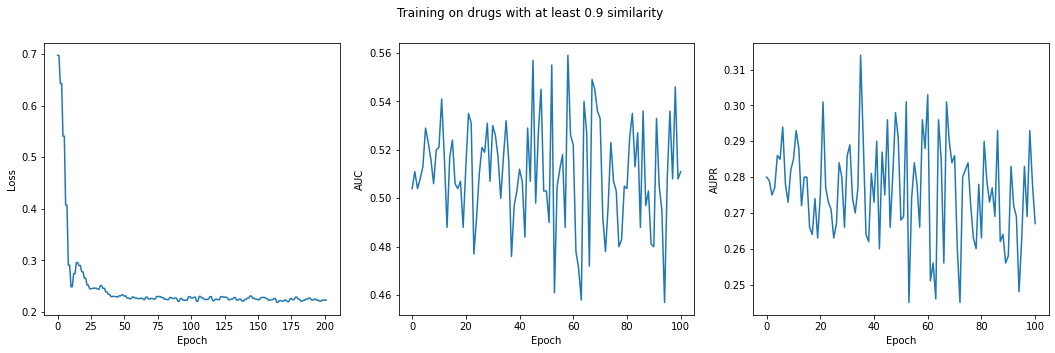

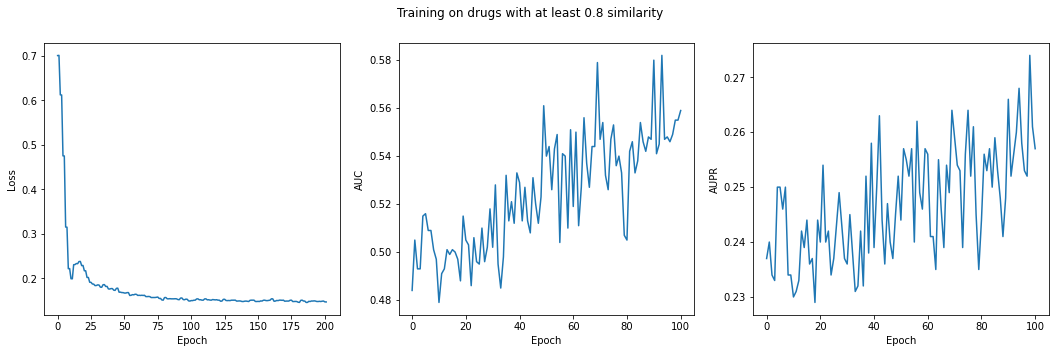

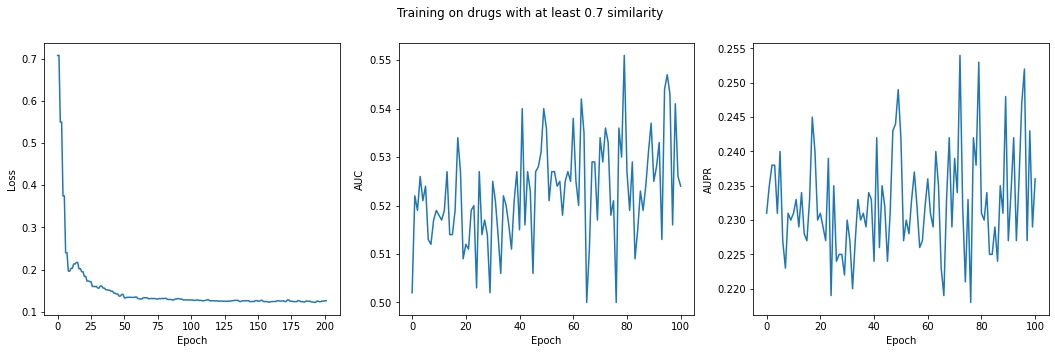

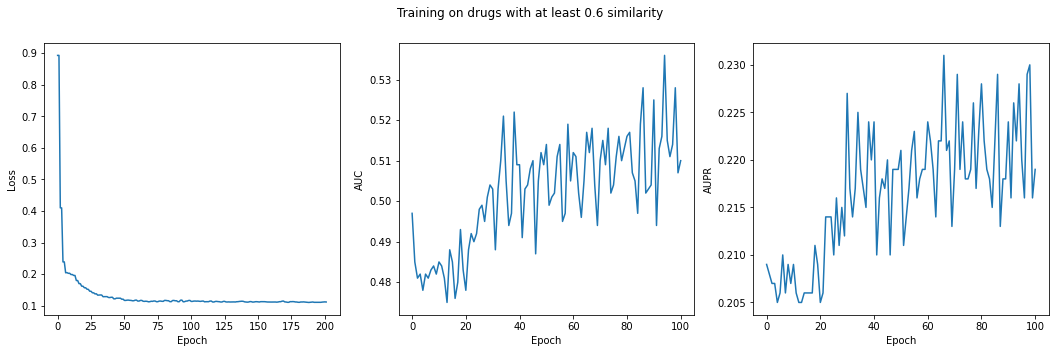

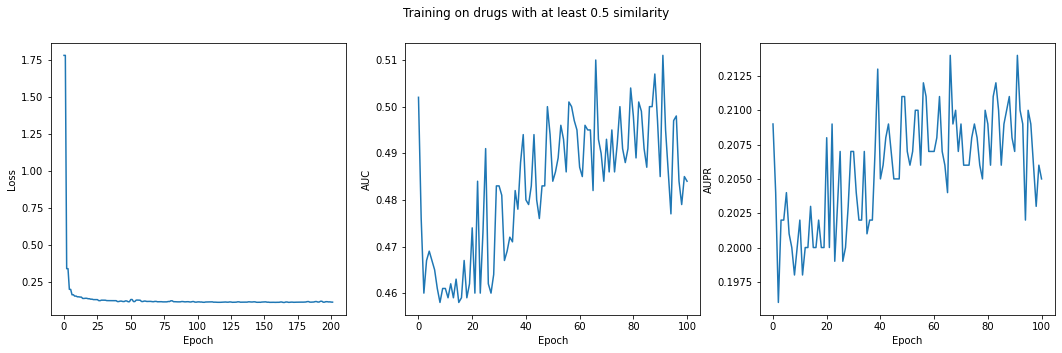

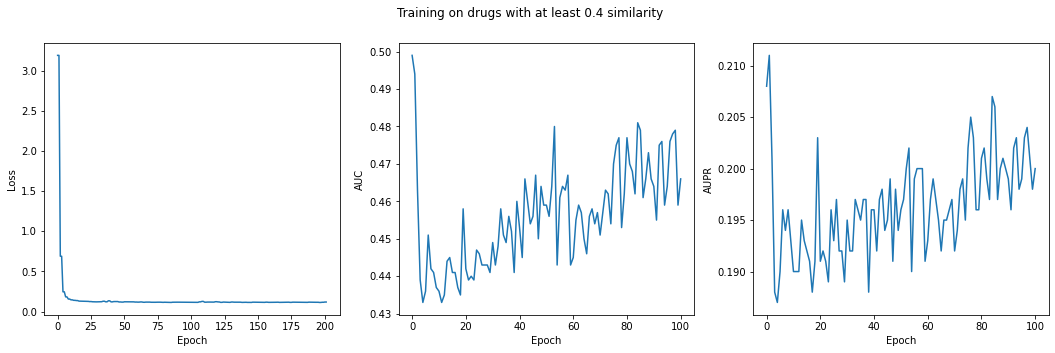

In [65]:
# loop on min_similarity scores
for i in range(len(score_list)):
    min_score = score_list[i][0]
    loss_list = score_list[i][1]
    auc_list = score_list[i][2]
    aupr_list = score_list[i][3]
    plot_different_results(loss_list, auc_list, aupr_list, min_score)


In [71]:
# t = pd.DataFrame(temp)
# t.to_csv(f'{base_dir}/generated/result.csv', index=False)

In [20]:
t = pd.read_csv(f'{base_dir}/generated/result.csv')
score_list = []
for row in t.values:
    similarity_score = row[0]
    losses = row[1].replace('[', '').replace(']', '').split(', ')
    losses = [float(loss) for loss in losses]
    loss_list = []
    for i in range(len(losses)):
        if i % 2 == 1:
            loss_list.append(losses[i])
    auc_list = row[2].replace('[', '').replace(']', '').split(', ')
    auc_list = [float(auc) for auc in auc_list]
    aupr_list = row[3].replace('[', '').replace(']', '').split(', ')
    aupr_list = [float(aupr) for aupr in aupr_list]
    score_list.append([similarity_score, loss_list, auc_list, aupr_list])

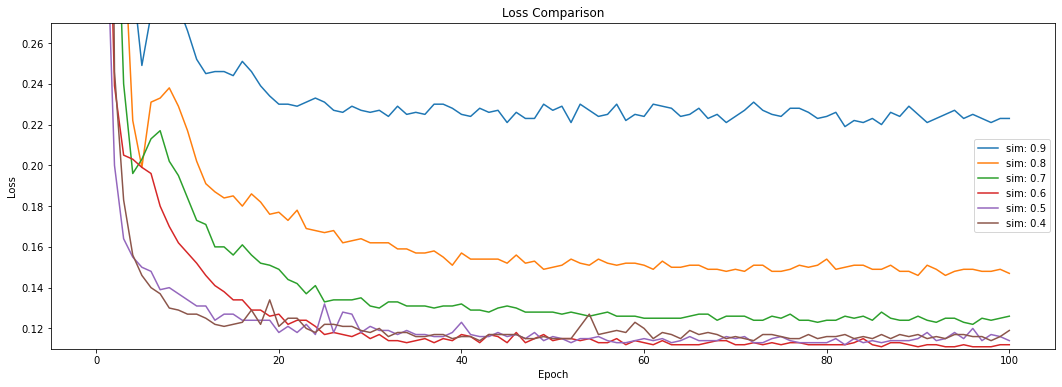

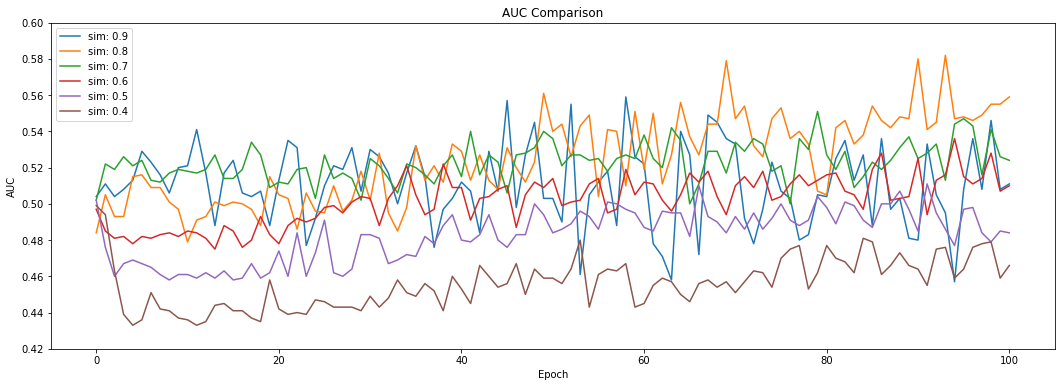

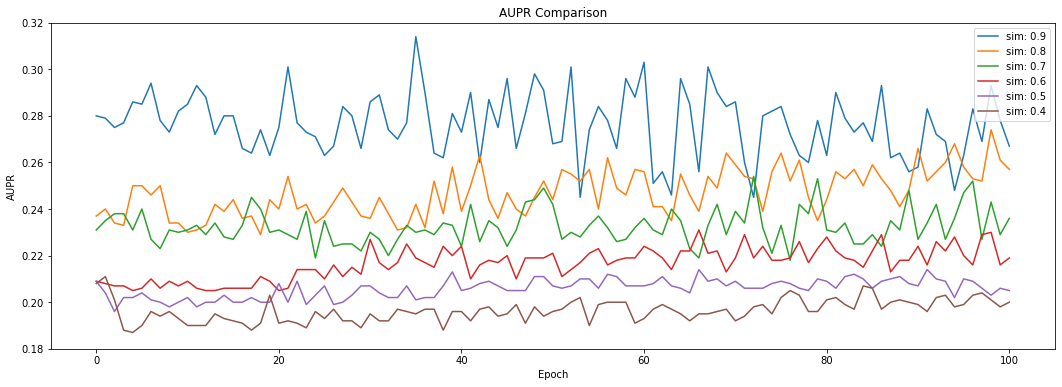

In [73]:
plt.figure(figsize=(18, 6))
plt.ylim(0.11, 0.27)
for i, row in enumerate(score_list):
    similarity_score = row[0]
    loss_list = row[1]
    plt.plot(loss_list, label=f'sim: {similarity_score}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.show()

plt.figure(figsize=(18, 6))
plt.ylim(0.42, 0.6)
for i, row in enumerate(score_list):
    similarity_score = row[0]
    auc_list = row[2]
    plt.plot(auc_list, label=f'sim: {similarity_score}')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC Comparison')
plt.legend()
plt.show()

plt.figure(figsize=(18, 6))
plt.ylim(0.18, 0.32)
for i, row in enumerate(score_list):
    similarity_score = row[0]
    aupr_list = row[3]
    plt.plot(aupr_list, label=f'sim: {similarity_score}')
plt.xlabel('Epoch')
plt.ylabel('AUPR')
plt.title('AUPR Comparison')
plt.legend()
plt.show()